<a href="https://colab.research.google.com/github/jiricejchan/AnonymniAnalytici/blob/master/cluster_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get This Notebook

Clik on `file` (upper left corner) and choose from the dropdown the option, which you prefer:
- `Save a copy in Drive` to add the notebook to your Google Drive (where you can access it via Google Colab)
- `Download .ipynb` to download the Notebook as a Jupyter Notebook, which you can run from your local machine

# Before we start: Setup

Before we start coding out the solution, make sure you have all the prerequisite Python packages. Run the following code to install the versions of the packages you will be needing for this Notebook.

In [ ]:
# Install necessary pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas==1.0.5 matplotlib==3.2.2 seaborn==0.10.1 numpy==1.18.5 scikit-learn==0.22.2

# Problem Description: Segment travel reviews

You are given a dataset of travel reviews from TripAdvisor.com. The reviews are classified into 10 categories for each reviewer who traveled through East Asia and gave feedback on one of the 10 categories. For each traveler you get their average score for that specific category: Excellent (4), Very Good (3), Average (2), Poor (1), and Terrible (0). Your task is to discover whether you can classify travelers into distinct clusters using the K-means algorithm.

The dataset can be [found here](https://archive.ics.uci.edu/ml/datasets/Travel+Reviews).
</br>
</br>

### Attribute Information

User ID : Unique user id</br>
Category 1 : Average user feedback on art galleries</br>
Category 2 : Average user feedback on dance clubs</br>
Category 3 : Average user feedback on juice bars</br>
Category 4 : Average user feedback on restaurants</br>
Category 5 : Average user feedback on museums</br>
Category 6 : Average user feedback on resorts</br>
Category 7 : Average user feedback on parks/picnic spots</br>
Category 8 : Average user feedback on beaches</br>
Category 9 : Average user feedback on theaters</br>
Category 10 : Average user feedback on religious institutions</br>

# STEP 1: Load & inspect data

In [ ]:
import pandas as pd

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv'

# read data into a pandas dataframe
df = pd.read_csv(data_url)

# check the first 5 rows to get a feeling of the data
df.head()

,User ID,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,User 1,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,User 2,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,User 3,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,User 4,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,User 5,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


# STEP 2: Exploratory Data Analysis (EDA) & Data Cleaning
Inspect and visualize the data to notice trends.

Clean the data according to [best practices](https://www.keboola.com/blog/the-ultimate-guide-to-data-cleaning).

Let us start by looking at descriptive statistics.

In [ ]:
# get descriptive statistics for each column/feature
df.describe(include='all')

,User ID,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
count,980,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
unique,980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,User 859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.893194,1.352612,1.013306,0.532500,0.939735,1.842898,3.180939,2.835061,1.569439,2.799224
std,NaN,0.326912,0.478280,0.788607,0.279731,0.437430,0.539538,0.007824,0.137505,0.364629,0.321380
min,NaN,0.340000,0.000000,0.130000,0.150000,0.060000,0.140000,3.160000,2.420000,0.740000,2.140000
25%,NaN,0.670000,1.080000,0.270000,0.410000,0.640000,1.460000,3.180000,2.740000,1.310000,2.540000
50%,NaN,0.830000,1.280000,0.820000,0.500000,0.900000,1.800000,3.180000,2.820000,1.540000,2.780000
75%,NaN,1.020000,1.560000,1.572500,0.580000,1.200000,2.200000,3.180000,2.910000,1.760000,3.040000


The information above is useful to understand the top down statistics of data (e.g. mean, median, standard deviation), but this works even better, if we visualize the data.

Before we visualize it, though, let us clean it a bit.

Check if there are any **missing values** within the dataframe.

In [ ]:
# count the number of rows with missing values per column
df.isna().sum()

User ID        0
Category 1     0
Category 2     0
Category 3     0
Category 4     0
Category 5     0
Category 6     0
Category 7     0
Category 8     0
Category 9     0
Category 10    0
dtype: int64

All good! No information is missing, so we do not have to remove anything at this moment.

For the next step, we check data distribution, and whether there are any **outliers**. We do it by visualizing the data with box plots.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


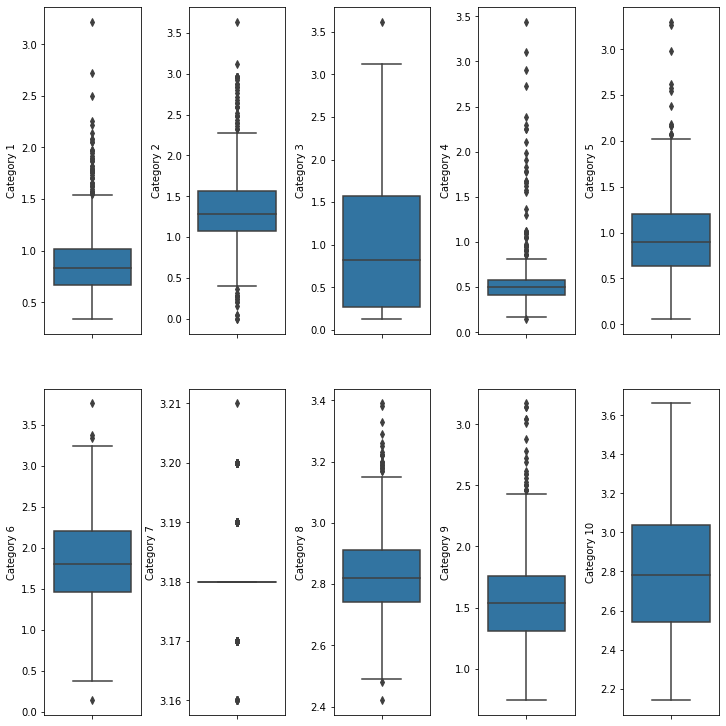

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# prepare a dataframe without the column 'User ID' since it is categorical and cannot be visualized
data_without_user_id = df.drop(['User ID'], axis=1)
data_without_user_id.head()

fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(10, 10))
index = 0
axs = axs.flatten()
for k,v in data_without_user_id.items():
    sns.boxplot(y=k, data=data_without_user_id, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

From the Box plot we can see that almost every feature has outliers. Which can be extremely problematic for K-means. This is especially the case for the features 'Category 4' (Average user feedback on restaurants) and 'Category 7' (Average user feedback on parks/picnic spots).

There are three options with outliers and K-means:
1. We remove the users whose ratings are outliers.
2. We remove the features which suffer from outliers.
3. We use K-medoids clustering, instead of the K-means algorithm.

For the time being, we will leave the data as it is. You can revisit this issue later and improve upon the algorithm.

## STEP 3: Train and evaluate a K-means solution

We start by using the Elbow method to determine the optimal number of clusters.

Text(0, 0.5, 'Sum of squared distance (SSE)')

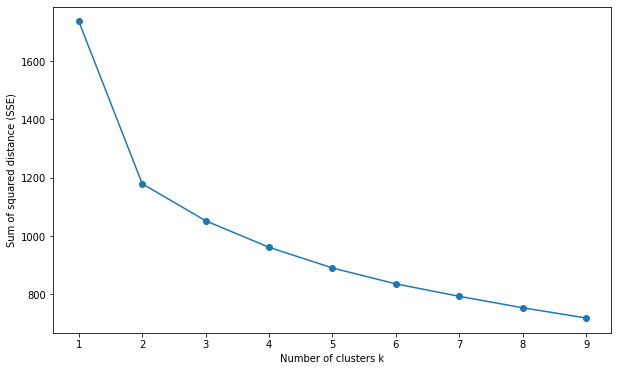

In [ ]:
from sklearn.cluster import KMeans

# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(data_without_user_id)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(10, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance (SSE)')

# uncomment to save figure to local machine
# plt.savefig('elbow_method_determination_of_k.png')

The Elbow method is subjective. But it seems the biggest decrease in SSE happened going from 1 cluster to 2. So k=2 is where the eblow is and that is the ideal number of clusters.

Let us evaluate how good this solution is with the Silhouette analysis. We will compare the solution found via the elbow method to k=3 and k=4. (check [Dabbura's article](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a) to dig deeper into the code)

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_without_user_id)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_without_user_id, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.30085279300986595
For n_clusters = 3 The average silhouette_score is : 0.2057566603020218
For n_clusters = 4 The average silhouette_score is : 0.16907960779865971


**Interpretation**: </br>
Both the elbow method and the silhouette analysis agree: 2 is the ideal number of clusters for segmenting reviewers.

However, it is clear from the silhouette score, that this clustering analysis has a lot of room for improvement.

# Your turn
Improve the model, to perform better than the baseline above.

A couple of things you can explore:
1. Does the model performance improve once we remove outliers?
2. How does feature normalization affect model performance?
3. What other features could you construct to improve the model?